# Predicting BBQ Weather using Classification Modeling

Lynn Anderson

# Business Understanding

All Fired Up is a renowned barbeque and grill restaurant located in Heathrow, UK. They serve from their kitchen every day, and weather permitting, they  serve up freshly grilled food featuring a variety of real hardwood lump charcoal. They are famous throughout the city for their charcoal grilled foods, and whenever the outdoor grills are open, get lots more business. However, setting up the outdoor charcoal grills takes a lot of time and resources, so it is only worth it to fire up the charcoal and run the grill if it is nearly certain to be a nice day for barbequing. Thus, it will be important for my classification model to have a very low rate of false positive errors (ie a predicted 'good' day that is actually not suitable for a bbq).
Precision will be an important metric, so I wil look at that and AUC as the most important metrics when evaluating models. 


# Data Understanding

The dataset consisted of two csv files- one containing records for in different cities, and the other with boolean values for whether it was a good bbq day. I was only interested in data related to the city of Heathrow, so removed irrelevant columns before performing any exploratory analysis. 

# Data Preparation

In [68]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, confusion_matrix, mean_squared_error, roc_curve, auc
from sklearn.feature_selection import (VarianceThreshold, SelectKBest, f_regression, mutual_info_regression, 
    RFE, RFECV)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [28]:
# read in weather records 
df = pd.read_csv('data/weather_prediction_dataset.csv')
df.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


Each row contains weather related data for 18 different locations from a specific date.

In [29]:
# read in associated bbq labels
df_labels = pd.read_csv('data/weather_prediction_bbq_labels.csv')
df_labels.head()

,DATE,BASEL_BBQ_weather,BUDAPEST_BBQ_weather,DE_BBQ_weather,DRESDEN_BBQ_weather,DUSSELDORF_BBQ_weather,HEATHROW_BBQ_weather,KASSEL_BBQ_weather,LJUBLJANA_BBQ_weather,MAASTRICHT_BBQ_weather,MALMO_BBQ_weather,MONTELIMAR_BBQ_weather,MUENCHEN_BBQ_weather,OSLO_BBQ_weather,PERPIGNAN_BBQ_weather,SONNBLICK_BBQ_weather,STOCKHOLM_BBQ_weather,TOURS_BBQ_weather
0,20000101,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,20000102,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,20000103,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,20000104,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,20000105,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Each row contains information regarding whether or not it was suitable for a bbq in a specific location on that day.

In [30]:
#verify date columns from both dataframes are identical
sum(df_labels['DATE'] != df['DATE'])

0

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Columns: 165 entries, DATE to TOURS_temp_max
dtypes: float64(150), int64(15)
memory usage: 4.6 MB


The full dataset contains 165 columns and 3,654 rows. Before any modeling, I will be removing columns not related to Heathrow weather.

In [32]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   DATE                    3654 non-null   int64
 1   BASEL_BBQ_weather       3654 non-null   bool 
 2   BUDAPEST_BBQ_weather    3654 non-null   bool 
 3   DE_BBQ_weather          3654 non-null   bool 
 4   DRESDEN_BBQ_weather     3654 non-null   bool 
 5   DUSSELDORF_BBQ_weather  3654 non-null   bool 
 6   HEATHROW_BBQ_weather    3654 non-null   bool 
 7   KASSEL_BBQ_weather      3654 non-null   bool 
 8   LJUBLJANA_BBQ_weather   3654 non-null   bool 
 9   MAASTRICHT_BBQ_weather  3654 non-null   bool 
 10  MALMO_BBQ_weather       3654 non-null   bool 
 11  MONTELIMAR_BBQ_weather  3654 non-null   bool 
 12  MUENCHEN_BBQ_weather    3654 non-null   bool 
 13  OSLO_BBQ_weather        3654 non-null   bool 
 14  PERPIGNAN_BBQ_weather   3654 non-null   bool 
 15  SONNBLICK_BBQ_weather

I will be looking at Heathrow bbq weather as my target variable. All values besides date are of type boolean. 

In [33]:
# investigate all columns
list(df.columns)

['DATE',
 'MONTH',
 'BASEL_cloud_cover',
 'BASEL_humidity',
 'BASEL_pressure',
 'BASEL_global_radiation',
 'BASEL_precipitation',
 'BASEL_sunshine',
 'BASEL_temp_mean',
 'BASEL_temp_min',
 'BASEL_temp_max',
 'BUDAPEST_cloud_cover',
 'BUDAPEST_humidity',
 'BUDAPEST_pressure',
 'BUDAPEST_global_radiation',
 'BUDAPEST_precipitation',
 'BUDAPEST_sunshine',
 'BUDAPEST_temp_mean',
 'BUDAPEST_temp_max',
 'DE_BILT_cloud_cover',
 'DE_BILT_wind_speed',
 'DE_BILT_wind_gust',
 'DE_BILT_humidity',
 'DE_BILT_pressure',
 'DE_BILT_global_radiation',
 'DE_BILT_precipitation',
 'DE_BILT_sunshine',
 'DE_BILT_temp_mean',
 'DE_BILT_temp_min',
 'DE_BILT_temp_max',
 'DRESDEN_cloud_cover',
 'DRESDEN_wind_speed',
 'DRESDEN_wind_gust',
 'DRESDEN_humidity',
 'DRESDEN_global_radiation',
 'DRESDEN_precipitation',
 'DRESDEN_sunshine',
 'DRESDEN_temp_mean',
 'DRESDEN_temp_min',
 'DRESDEN_temp_max',
 'DUSSELDORF_cloud_cover',
 'DUSSELDORF_wind_speed',
 'DUSSELDORF_wind_gust',
 'DUSSELDORF_humidity',
 'DUSSELDORF_pres

I am interested in the columns containing data for Heathrow. I will select only those and make a new dataframe.

In [34]:
# dataframe with only info pertaining to Heathrow

base_df_heathrow = df[['DATE', 'MONTH', 'HEATHROW_cloud_cover', 'HEATHROW_humidity', 'HEATHROW_pressure',
                 'HEATHROW_global_radiation', 'HEATHROW_precipitation', 'HEATHROW_sunshine', 'HEATHROW_temp_mean',
                 'HEATHROW_temp_min', 'HEATHROW_temp_max']]

# add HEATHROW_BBQ_weather column to dataframe

base_df_heathrow['HEATHROW_BBQ_weather'] = df_labels['HEATHROW_BBQ_weather']

base_df_heathrow.head()

C:\Users\lalyn\AppData\Local\Temp\ipykernel_5332\1711984132.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df_heathrow['HEATHROW_BBQ_weather'] = df_labels['HEATHROW_BBQ_weather']


,DATE,MONTH,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_BBQ_weather
0,20000101,1,7,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8,False
1,20000102,1,7,0.89,1.0253,0.20,0.02,0.7,7.9,5.0,11.5,False
2,20000103,1,8,0.91,1.0186,0.13,0.60,0.0,9.4,7.2,9.5,False
3,20000104,1,5,0.89,1.0148,0.34,0.02,2.9,7.0,4.4,11.0,False
4,20000105,1,5,0.85,1.0142,0.25,0.08,1.3,6.4,1.9,10.8,False


In [35]:
base_df_heathrow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DATE                       3654 non-null   int64  
 1   MONTH                      3654 non-null   int64  
 2   HEATHROW_cloud_cover       3654 non-null   int64  
 3   HEATHROW_humidity          3654 non-null   float64
 4   HEATHROW_pressure          3654 non-null   float64
 5   HEATHROW_global_radiation  3654 non-null   float64
 6   HEATHROW_precipitation     3654 non-null   float64
 7   HEATHROW_sunshine          3654 non-null   float64
 8   HEATHROW_temp_mean         3654 non-null   float64
 9   HEATHROW_temp_min          3654 non-null   float64
 10  HEATHROW_temp_max          3654 non-null   float64
 11  HEATHROW_BBQ_weather       3654 non-null   bool   
dtypes: bool(1), float64(8), int64(3)
memory usage: 317.7 KB


All columns are numeric. However, the month column is really categorical, and assigning numeric values to the months could interfere with the modeling. 

In [36]:
# create dictinary

month_labels = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August',
                9: 'September', 10: 'October', 11: 'November', 12: 'December'}


# replace with month name
base_df_heathrow['MONTH'].replace(month_labels, inplace=True)
base_df_heathrow

C:\Users\lalyn\AppData\Local\Temp\ipykernel_5332\614409533.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df_heathrow['MONTH'].replace(month_labels, inplace=True)


,DATE,MONTH,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,HEATHROW_BBQ_weather
0,20000101,January,7,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8,False
1,20000102,January,7,0.89,1.0253,0.20,0.02,0.7,7.9,5.0,11.5,False
2,20000103,January,8,0.91,1.0186,0.13,0.60,0.0,9.4,7.2,9.5,False
3,20000104,January,5,0.89,1.0148,0.34,0.02,2.9,7.0,4.4,11.0,False
4,20000105,January,5,0.85,1.0142,0.25,0.08,1.3,6.4,1.9,10.8,False
...,...,...,...,...,...,...,...,...,...,...,...,...
3649,20091228,December,2,0.90,1.0043,0.37,0.06,3.7,1.7,-2.2,5.0,False
3650,20091229,December,8,0.92,0.9949,0.12,1.28,0.0,1.9,-1.2,5.2,False
3651,20091230,December,8,0.97,0.9923,0.12,0.36,0.0,4.6,4.0,4.4,False
3652,20091231,December,7,0.83,0.9993,0.13,0.00,0.0,3.9,3.3,3.6,False


In [37]:
base_df_heathrow['MONTH'].value_counts()

January      311
March        310
May          310
July         310
August       310
October      310
December     310
April        300
June         300
September    300
November     300
February     283
Name: MONTH, dtype: int64

There does not appear to be any anomalies with the month column.

In [38]:
base_df_heathrow.describe()

,DATE,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,5.272031,0.758358,1.015192,1.196970,0.178279,4.433498,11.822386,8.002737,15.637438
std,2.874287e+04,2.011846,0.102410,0.010561,0.881638,0.367572,3.982646,5.610018,5.230449,6.385440
min,2.000010e+07,0.000000,0.420000,0.971500,0.120000,0.000000,0.000000,-2.200000,-6.800000,0.200000
25%,2.002070e+07,4.000000,0.690000,1.009000,0.430000,0.000000,0.600000,7.600000,4.100000,10.800000
50%,2.004567e+07,6.000000,0.760000,1.016000,0.960000,0.020000,3.700000,11.700000,8.250000,15.400000
75%,2.007070e+07,7.000000,0.840000,1.022100,1.860000,0.180000,7.200000,16.300000,12.100000,20.500000
max,2.010010e+07,8.000000,1.000000,1.043800,3.490000,3.660000,15.500000,29.000000,20.600000,37.900000


In [39]:
#check for null values
base_df_heathrow.isnull().sum()

DATE                         0
MONTH                        0
HEATHROW_cloud_cover         0
HEATHROW_humidity            0
HEATHROW_pressure            0
HEATHROW_global_radiation    0
HEATHROW_precipitation       0
HEATHROW_sunshine            0
HEATHROW_temp_mean           0
HEATHROW_temp_min            0
HEATHROW_temp_max            0
HEATHROW_BBQ_weather         0
dtype: int64

No null values to deal with.

In [40]:
# check porportions of target variable
base_df_heathrow['HEATHROW_BBQ_weather'].value_counts()

False    2785
True      869
Name: HEATHROW_BBQ_weather, dtype: int64

The weather was suitable for a bbq on about 24% of the recorded dates. This is not extremely imbalanced but, but it will be necessary to keep in mind that a 'dummy' model that predicts False will be correct about 75% of the time.

# Data Visualization

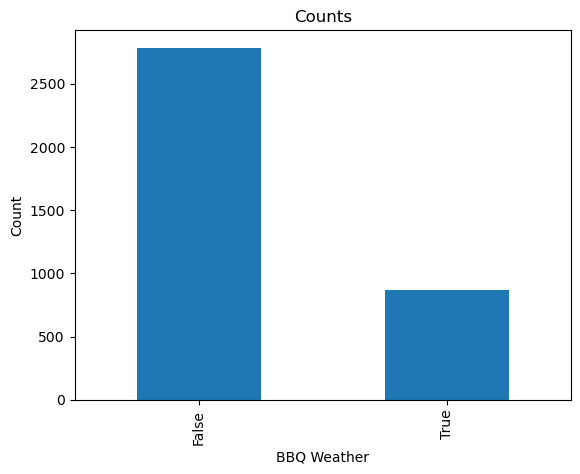

In [44]:
base_df_heathrow['HEATHROW_BBQ_weather'].value_counts().plot.bar(title='Counts', ylabel='Count').set_xlabel('BBQ Weather');


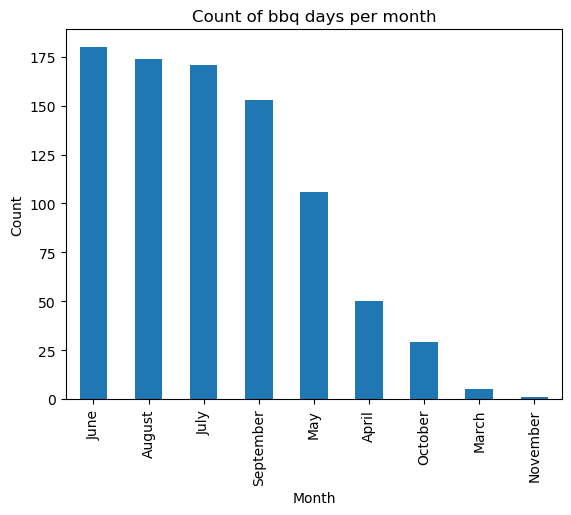

In [45]:
# plot number of good weather days by month

bbq = base_df_heathrow.loc[base_df_heathrow['HEATHROW_BBQ_weather'] == True]
bbq['MONTH'].value_counts().plot.bar(title='Count of bbq days per month', ylabel='Count').set_xlabel('Month');


Not surprisingly, the summer months had by far the highest number of good days. November and March had very few.

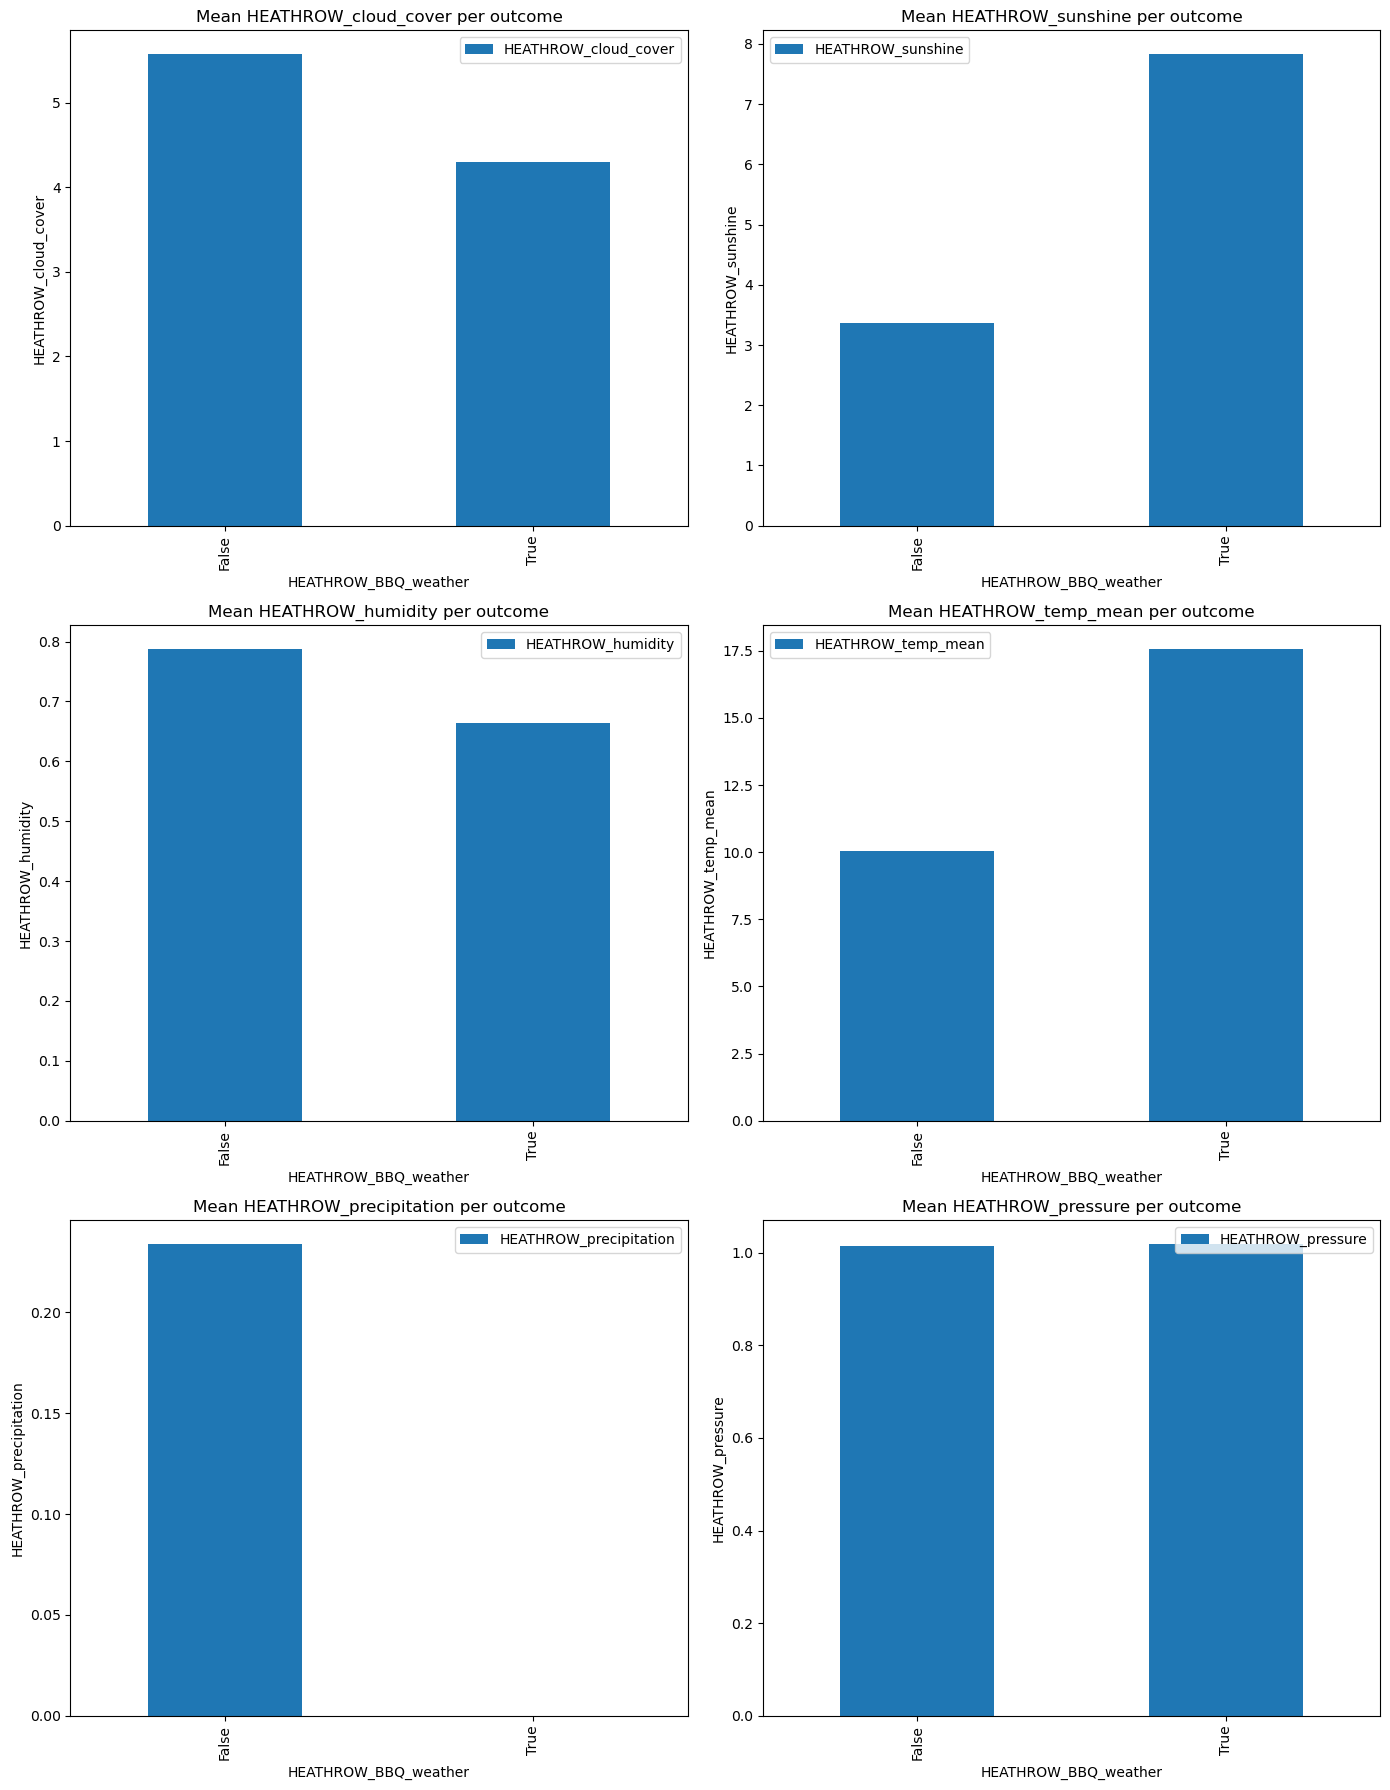

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,18))
for i, col in enumerate(['HEATHROW_cloud_cover', 'HEATHROW_humidity', 'HEATHROW_precipitation', 'HEATHROW_sunshine', 'HEATHROW_temp_mean', 'HEATHROW_pressure']):
    base_df_heathrow.groupby('HEATHROW_BBQ_weather').mean().plot.bar(y=col, ylabel=col, title= 'Mean ' + col + ' per outcome', ax=axes[i%3][i//3]);
plt.tight_layout();

Just from observing the plots, 

# Modeling

In [47]:
# get dummy columns for month
df_heathrow = pd.get_dummies(base_df_heathrow)
df_heathrow.head()

,DATE,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,...,MONTH_December,MONTH_February,MONTH_January,MONTH_July,MONTH_June,MONTH_March,MONTH_May,MONTH_November,MONTH_October,MONTH_September
0,20000101,7,0.94,1.0245,0.18,0.00,0.4,7.0,4.9,10.8,...,0,0,1,0,0,0,0,0,0,0
1,20000102,7,0.89,1.0253,0.20,0.02,0.7,7.9,5.0,11.5,...,0,0,1,0,0,0,0,0,0,0
2,20000103,8,0.91,1.0186,0.13,0.60,0.0,9.4,7.2,9.5,...,0,0,1,0,0,0,0,0,0,0
3,20000104,5,0.89,1.0148,0.34,0.02,2.9,7.0,4.4,11.0,...,0,0,1,0,0,0,0,0,0,0
4,20000105,5,0.85,1.0142,0.25,0.08,1.3,6.4,1.9,10.8,...,0,0,1,0,0,0,0,0,0,0


In [48]:
# define X and y
X = df_heathrow.drop(['DATE', 'HEATHROW_BBQ_weather'],axis=1)
y = df_heathrow['HEATHROW_BBQ_weather']

In [49]:
X.shape

(3654, 21)

#### Train-test split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

The data is now ready for classification modeling.

### Basic logistic regression model

In [51]:
# instantiate model 

logreg = LogisticRegression(fit_intercept=False, C=1, solver='liblinear')

# Fit to training data
log_model = logreg.fit(X_train, y_train)
log_model

LogisticRegression(C=1, fit_intercept=False, solver='liblinear')

#### Model evaluation

In [56]:
log_model_y_pred = log_model.predict(X_test)

print(classification_report(y_test, log_model_y_pred))
print("F1 score: ", f1_score(y_test, log_model_y_pred))

              precision    recall  f1-score   support

       False       0.94      0.97      0.96       548
        True       0.90      0.83      0.86       183

    accuracy                           0.93       731
   macro avg       0.92      0.90      0.91       731
weighted avg       0.93      0.93      0.93       731

F1 score:  0.8628571428571429


..

In [278]:
# investigate AUC for train and test data
log_model_y_train_score = logreg.decision_function(X_train)
log_model_y_test_score = logreg.decision_function(X_test)
log_model_y_pred = log_model.predict(X_test)
log_model_train_fpr, log_model_train_tpr, log_model_train_thresholds = roc_curve(y_train, log_model_y_train_score)
log_model_test_fpr, log_model_test_tpr, log_model_test_thresholds = roc_curve(y_test, log_model_y_test_score)

print('Train AUC: {}'.format(auc(log_model_train_fpr, log_model_train_tpr)))
print('Test AUC: {}'.format(auc(log_model_test_fpr, log_model_test_tpr)))



Train AUC: 0.9785439943906549
Test AUC: 0.9835566989749113


..

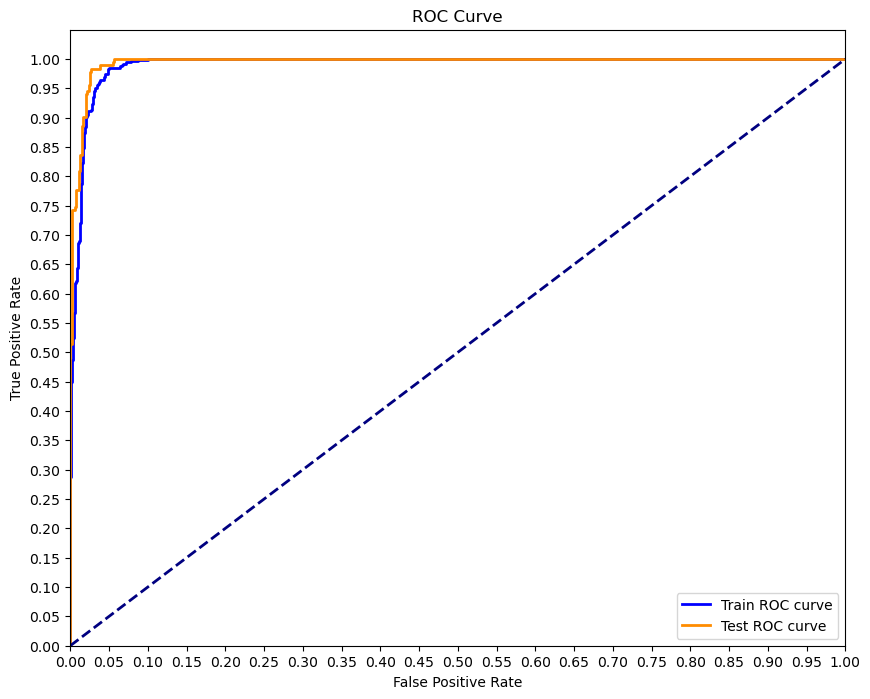

In [258]:
plt.figure(figsize=(10, 8))
lw = 2

plt.plot(train_fpr, train_tpr, color='blue',
         lw=lw, label='Train ROC curve')
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='Test ROC curve')


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [279]:
c_vals = [1, 5, 10, 50, 100]
best_C = None 
best_auc = 0.0

for n in c_vals:
    
    logreg = LogisticRegression(fit_intercept=False, C=n, solver='liblinear')
    logreg.fit(X_train, y_train)
    
     f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    y_test_score = logreg.decision_function(X_test)
    y_train_score = logreg.decision_function(X_train)

    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
    
    test_auc = auc(test_fpr, test_tpr)
    train_auc = auc(train_fpr, train_tpr)
    
    if test_auc > best_auc:
            best_C = n
            best_auc = test_auc
    print(n, ':', 'train AUC: ', train_auc, 'Test AUC: ', test_auc)
print(best_C, best_auc)

1 : train AUC:  0.9785439943906549 Test AUC:  0.9835566989749113
5 : train AUC:  0.9859108213181178 Test AUC:  0.9913046946671453
10 : train AUC:  0.9890536967069861 Test AUC:  0.9933189741135175
50 : train AUC:  0.9940628783603613 Test AUC:  0.9972677595628415
100 : train AUC:  0.995657449390127 Test AUC:  0.9981751824817519
100 0.9981751824817519


print(classification_report(y_test, log_model_y_pred))

increasing C improves performance. 

### KNN Nearest Neighbors

In [57]:
# data must be scaled
scaler = StandardScaler()

# Transform the training and test sets
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_X_train, columns=X.columns)
scaled_df_train.head()

,HEATHROW_cloud_cover,HEATHROW_humidity,HEATHROW_pressure,HEATHROW_global_radiation,HEATHROW_precipitation,HEATHROW_sunshine,HEATHROW_temp_mean,HEATHROW_temp_min,HEATHROW_temp_max,MONTH_April,...,MONTH_December,MONTH_February,MONTH_January,MONTH_July,MONTH_June,MONTH_March,MONTH_May,MONTH_November,MONTH_October,MONTH_September
0,0.870739,0.798819,-0.752802,-0.425281,-0.366392,-1.014606,0.463634,0.845271,0.119255,-0.297726,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,-0.301793,-0.307159,-0.296362,-0.304484,-0.306492
1,-0.120564,-0.171650,-2.758235,-0.504851,-0.204199,-0.712971,-0.319709,-0.530019,-0.239577,-0.297726,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,3.313534,-0.307159,-0.296362,-0.304484,-0.306492
2,-1.607518,-1.918495,0.019243,1.291168,-0.474521,1.850919,-0.853807,-1.370474,-0.379990,3.358796,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,-0.301793,-0.307159,-0.296362,-0.304484,-0.306492
3,0.870739,0.022444,-0.263213,-0.766297,-0.474521,-0.134839,-0.123874,0.176727,-0.801227,-0.297726,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,-0.301793,-0.307159,3.374254,-0.304484,-0.306492
4,0.375088,1.284054,1.214970,-1.027743,-0.474521,-1.014606,-0.925020,-1.294069,-0.582808,-0.297726,...,-0.30314,-0.28177,-0.315096,-0.298406,-0.301117,-0.301793,-0.307159,3.374254,-0.304484,-0.306492


In [58]:
knn = KNeighborsClassifier()

# Fit the classifier
knn.fit(scaled_X_train, y_train)


# Predict on the test set
knn_test_preds = knn.predict(scaled_X_test)

C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


#### Model evaluation

In [59]:

print(classification_report(y_test, knn_test_preds))

print("F1 score: ", f1_score(y_test, knn_test_preds))

              precision    recall  f1-score   support

       False       0.94      0.94      0.94       548
        True       0.83      0.81      0.82       183

    accuracy                           0.91       731
   macro avg       0.88      0.88      0.88       731
weighted avg       0.91      0.91      0.91       731

F1 score:  0.8176795580110497


In [280]:
# Check the AUC of predictions
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_test_preds)
knn_auc = auc(knn_fpr, knn_tpr)
knn_auc

0.8760869131666069

...

In [69]:
k_vals = range(1, 25, 2)
best_k = 0
best_score = 0.0
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(scaled_X_train, y_train)
    preds = knn.predict(scaled_X_test)
        
    f1 = f1_score(y_test, preds)
    
    if f1 > best_score:
        best_k = k
        best_score = f1
        
    
print("Best Value for k: {}".format(best_k))
print("F1-Score: {}".format(best_score))


Best Value for k: 7
F1-Score: 0.8453038674033149


......

In [281]:
knn2 = KNeighborsClassifier(n_neighbors=7)

# Fit the classifier
knn2.fit(scaled_X_train, y_train)


# Predict on the test set
knn2_test_preds = knn2.predict(scaled_X_test)

C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [282]:
print(classification_report(y_test, knn2_test_preds))

              precision    recall  f1-score   support

       False       0.95      0.95      0.95       548
        True       0.85      0.84      0.85       183

    accuracy                           0.92       731
   macro avg       0.90      0.89      0.90       731
weighted avg       0.92      0.92      0.92       731



### Basic decision tree classifier

In [71]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

DecisionTreeClassifier()

#### Model evaluation

In [72]:
dt_y_pred = dt.predict(X_test)

print(classification_report(y_test, dt_y_pred))
print("F1 score: ", f1_score(y_test, dt_y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       548
        True       1.00      1.00      1.00       183

    accuracy                           1.00       731
   macro avg       1.00      1.00      1.00       731
weighted avg       1.00      1.00      1.00       731

F1 score:  1.0


In [73]:
# Check the AUC 
dt_fpr, dt_tpr, thresholds = roc_curve(y_test, dt_y_pred)
dt_auc = auc(dt_fpr, dt_tpr)
dt_auc

1.0

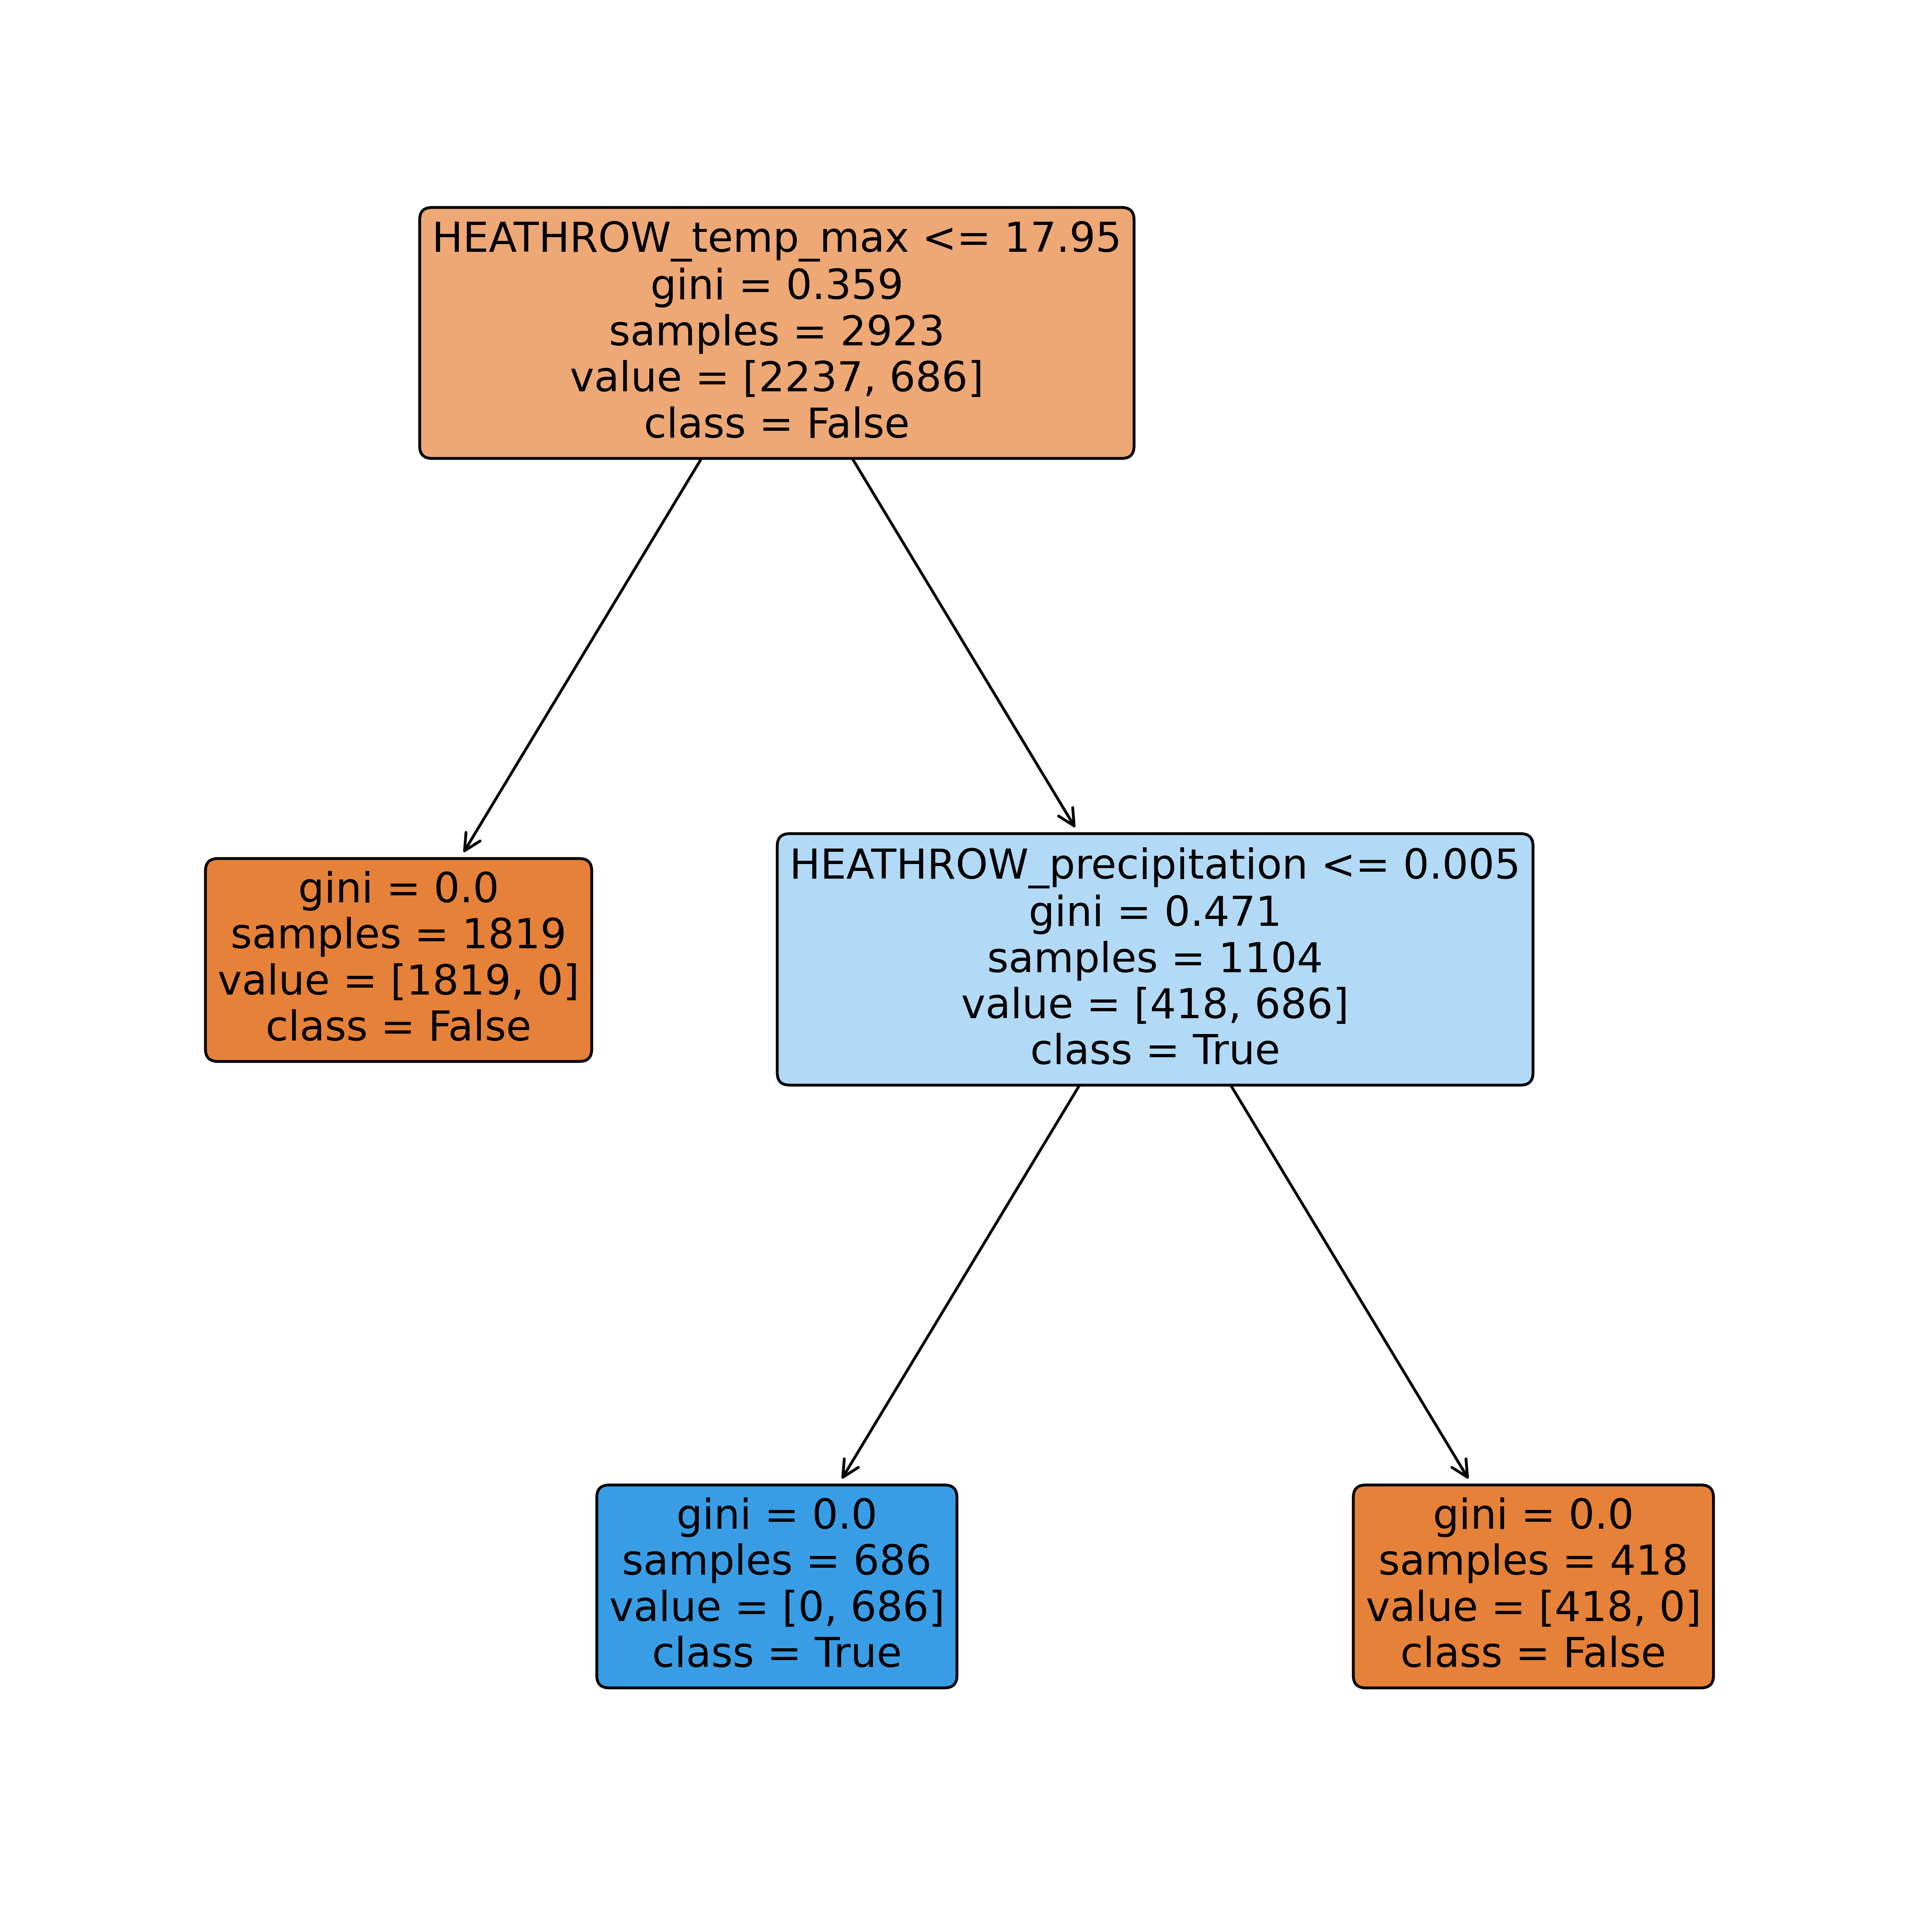

In [238]:
# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
tree.plot_tree(dt, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()


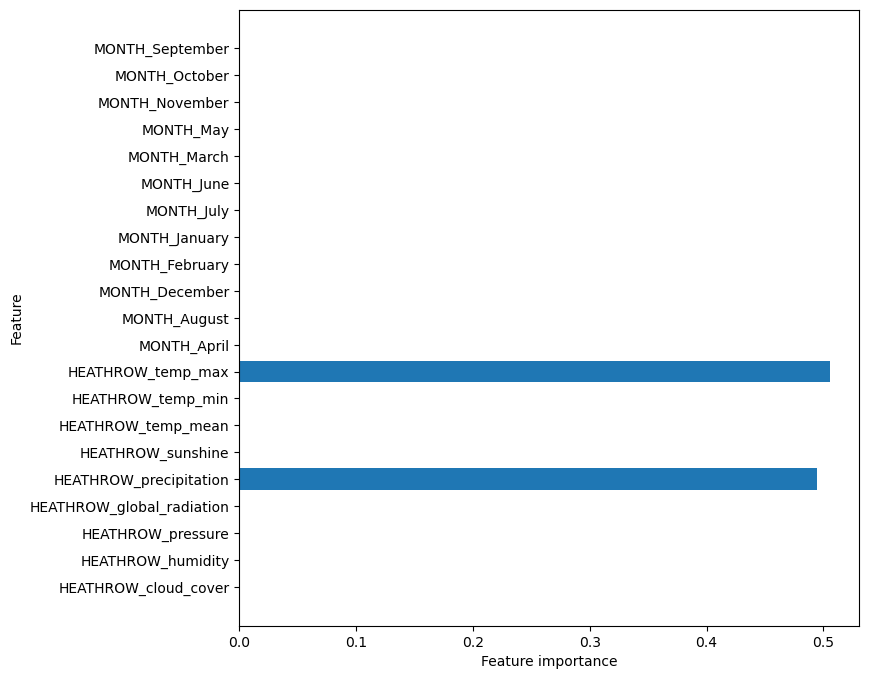

In [239]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(dt)

From this model, it appears ... are the only features that matter

### Random forest classifier

In [75]:
forest = RandomForestClassifier(n_estimators=75, max_depth= 5)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=75)

#### Model evaluation

In [78]:
forest_y_pred = forest.predict(X_test)

print(classification_report(y_test, forest_y_pred))
print("F1 score: ", f1_score(y_test, forest_y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       548
        True       1.00      0.99      1.00       183

    accuracy                           1.00       731
   macro avg       1.00      1.00      1.00       731
weighted avg       1.00      1.00      1.00       731

F1 score:  0.9972602739726028


In [284]:
# AUC 
forest_fpr, forest_tpr, thresholds = roc_curve(y_test, forest_y_pred)
forest_auc = auc(forest_fpr, forest_tpr)
forest_auc

0.9972677595628415

......

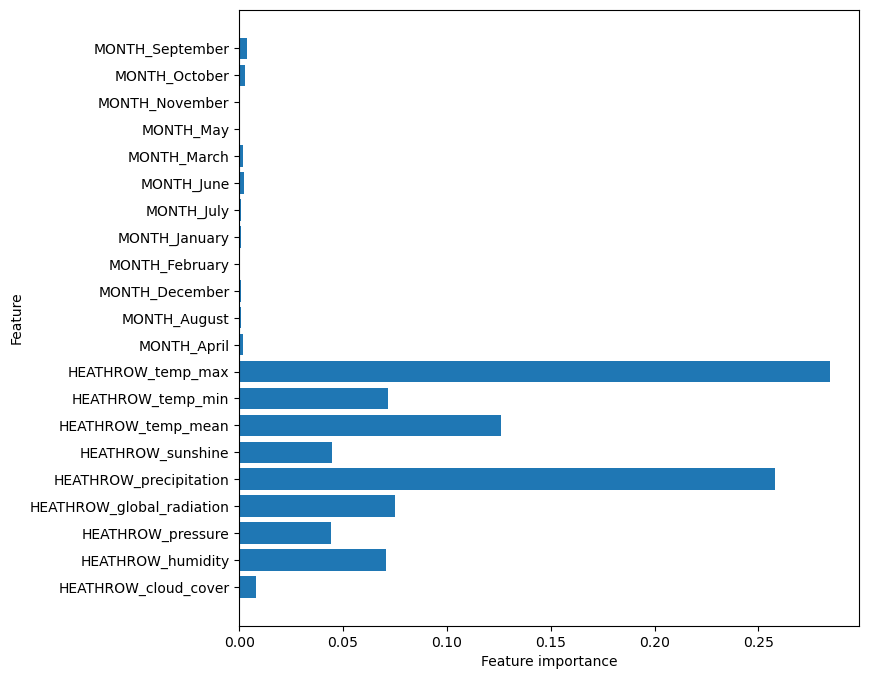

In [245]:
plot_feature_importances(forest)

Other features have importance

### Bagged tree

In [79]:

bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

# Fit to the training data
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

#### Model evaluation

In [80]:
bt_y_pred = bagged_tree.predict(X_test)

print(classification_report(y_test, bt_y_pred))
print("F1 score: ", f1_score(y_test, bt_y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00       548
        True       1.00      1.00      1.00       183

    accuracy                           1.00       731
   macro avg       1.00      1.00      1.00       731
weighted avg       1.00      1.00      1.00       731

F1 score:  1.0


In [81]:

# Check the AUC of predictions
bt_fpr, bt_tpr, thresholds = roc_curve(y_test, bt_y_pred)
bt_roc_auc = auc(bt_fpr, bt_tpr)
bt_roc_auc

1.0

# Evaluation

# Conclusion